# Comparison of some `scikit-learn` regressors

This example demonstrates the use of Polynomial Chaos estimation on the concrete compressive strength data set, and compares it with a Random Forest regressor. It includes partial dependence plots and plots of the (main-effect) Sobol sensitivity indices for comparison.

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# qualified imports
from scipy.stats import uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.linear_model import LassoCV
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.model_selection import train_test_split
from sklearn.polynomial_chaos import PolynomialChaosRegressor
from sklearn.preprocessing import MinMaxScaler

In [4]:
# for reproducibility
np.random.seed(2023)

## 1. Data preprocessing

In [5]:
# load the concrete compressive strength dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls"
data = pd.read_excel(url)
data

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [6]:
# select features and target variable
features = data.iloc[:, :-1]  # all columns except the last one
target = data.iloc[:, -1]     # the last column

In [7]:
# add some noise to the training data
target += 0.25 * np.std(target) * np.random.randn(len(target))

In [8]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [9]:
# standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 2. Random Forest regressor

In [10]:
# train a Random Forest regressor for comparison
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)
rf_predictions = rf_regressor.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mse

44.25065324153052

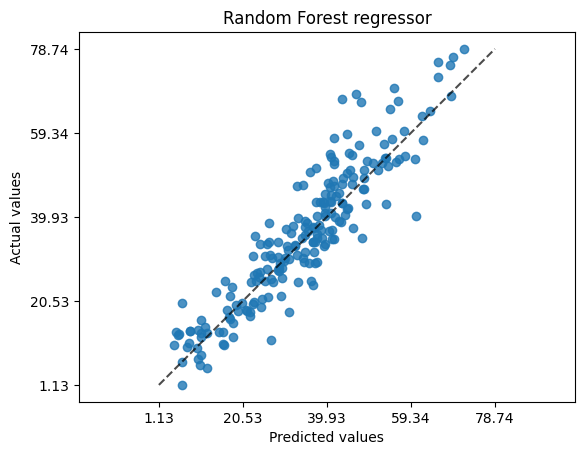

In [11]:
# visualize the prediction error
_, ax = plt.subplots()
PredictionErrorDisplay.from_estimator(rf_regressor, X_test_scaled, y_test, kind="actual_vs_predicted", ax=ax)
ax.set_title("Random Forest regressor")
plt.show()

## 3. Polynomial chaos regressor

In [12]:
# fit Polynomial Chaos expansion
solver = solver = LassoCV(
    fit_intercept=False,
    max_iter=100000
)
pc_regressor = PolynomialChaosRegressor([uniform()]*8, degree=3, solver=solver)
pc_regressor.fit(X_train_scaled, y_train)
pc_predictions = pc_regressor.predict(X_test_scaled)
pc_mse = mean_squared_error(y_test, pc_predictions)
pc_mse

61.50088516449582

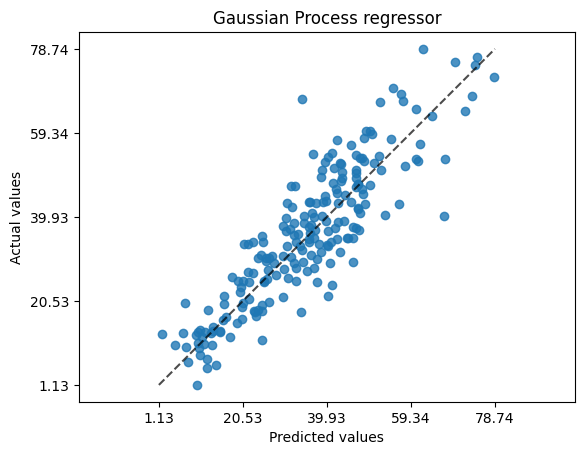

In [13]:
# visualize the prediction error
_, ax = plt.subplots()
PredictionErrorDisplay.from_estimator(pc_regressor, X_test_scaled, y_test, kind="actual_vs_predicted", ax=ax)
ax.set_title("Gaussian Process regressor")
plt.show()

## 4. Feature importance

In [14]:
# partial dependence plots (1)
rf_pdp = list()
pc_pdp = list()
for j in range(8):
    for display, regressor in [(rf_pdp, rf_regressor), (pc_pdp, pc_regressor)]:
        _, ax = plt.subplots()
        display.append(PartialDependenceDisplay.from_estimator(regressor, X_test_scaled, (j, ), ax=ax))
        plt.close()

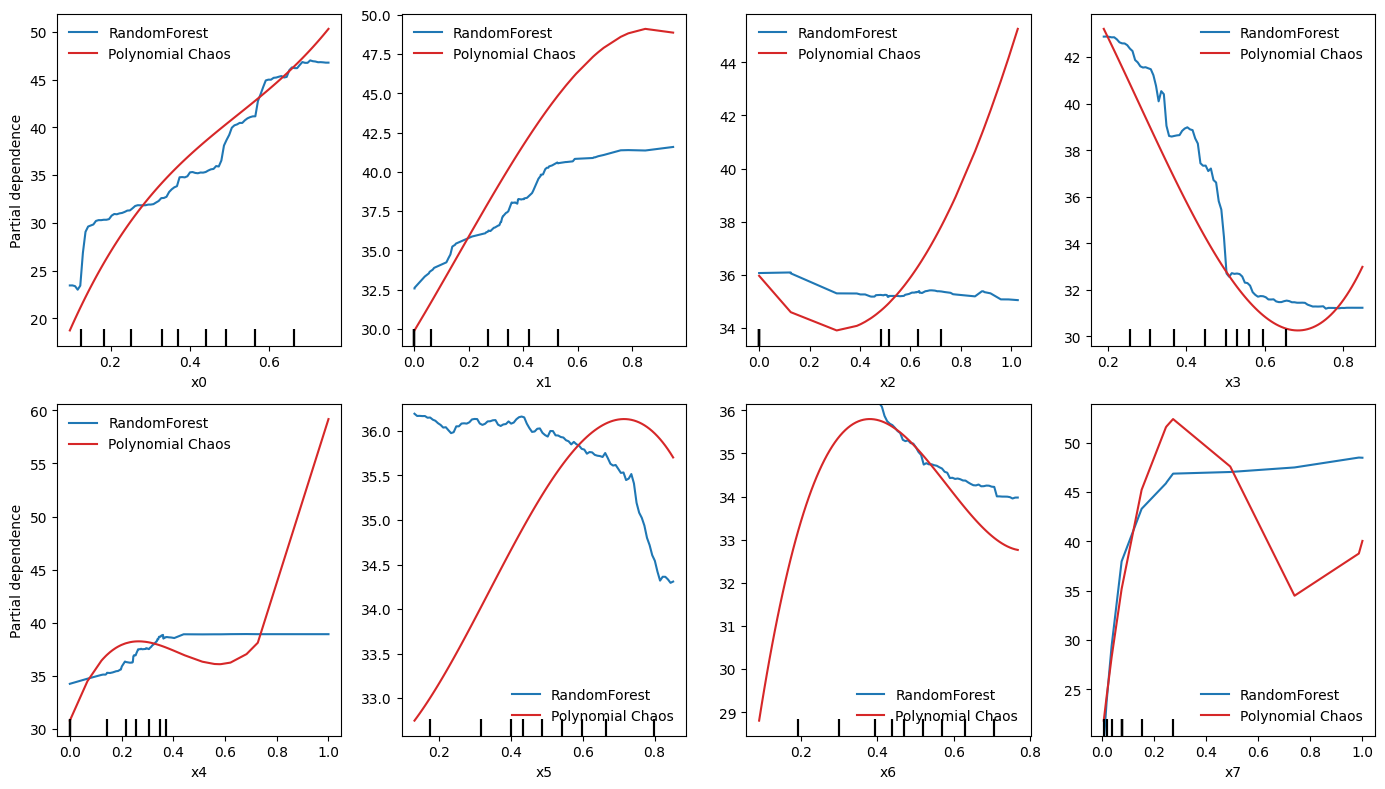

In [15]:
# partial dependence plots (2)
fig, axes = plt.subplots(2, 4, figsize=(14, 8))
for j, ax in enumerate(axes.flatten()):
    rf_pdp[j].plot(ax=[ax], line_kw={"label": "RandomForest"})
    pc_pdp[j].plot(ax=[ax], line_kw={"color": "C3", "label": "Polynomial Chaos"})
    ax.legend(frameon=False)
    if j % 4 != 0:
        ax.set_ylabel("")
fig.tight_layout()
fig.show()


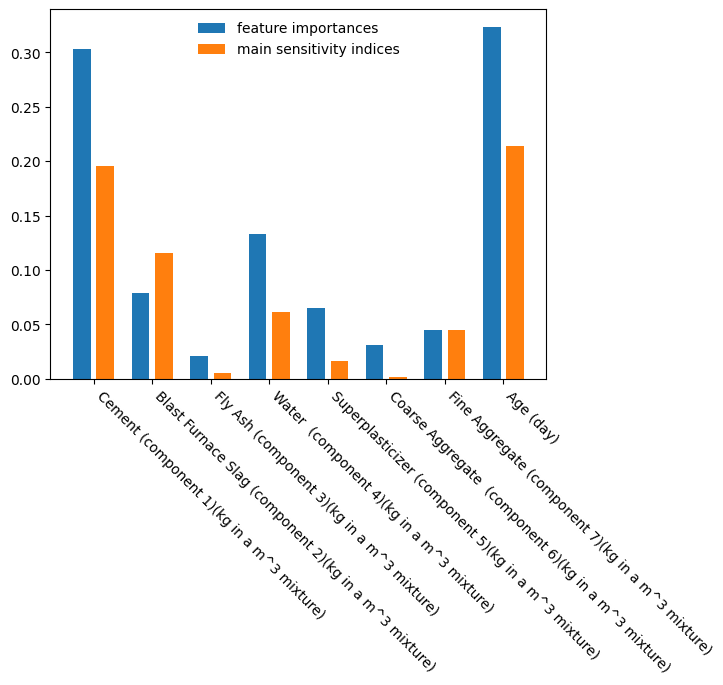

In [16]:
# partial dependence plots
fig, ax = plt.subplots()
ax.bar(np.arange(8) - 0.2, rf_regressor.feature_importances_, width=0.3, label="feature importances")
ax.bar(np.arange(8) + 0.2, pc_regressor.main_sens(), width=0.3, label="main sensitivity indices")
ax.legend(frameon=False)
ax.set_xticks(range(8))
ax.set_xticklabels(features.columns, rotation=-45, ha="left")
fig.show()